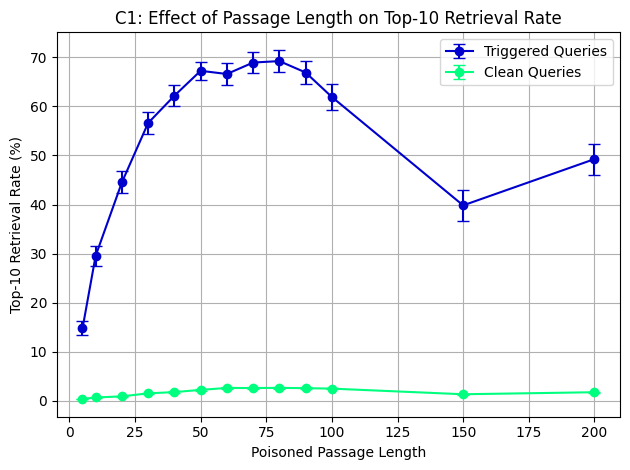

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results
df = pd.read_csv("../results/c1_25_7_passage_length.tsv", sep="\t")

# SEM function
def sem(x):
    return x.std(ddof=1) / np.sqrt(len(x))

# Group by passage length and compute mean + SEM for Top-10 retrieval rate
grouped = df.groupby("length").agg({
    "trigger_top10": ["mean", sem],
    "clean_top10": ["mean", sem]
}).reset_index()

# Flatten column names
grouped.columns = ['_'.join(col).strip() if col[1] else col[0] for col in grouped.columns.values]

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Plot
plt.figure()
plt.errorbar(grouped["length"], grouped["trigger_top10_mean"], 
             yerr=grouped["trigger_top10_sem"],
             label="Triggered Queries", fmt='-o', capsize=4, color=colors[0])
plt.errorbar(grouped["length"], grouped["clean_top10_mean"], 
             yerr=grouped["clean_top10_sem"],
             label="Clean Queries", fmt='-o', capsize=4, color=colors[1])

plt.xlabel("Poisoned Passage Length")
plt.ylabel("Top-10 Retrieval Rate (%)")
plt.title("C1: Effect of Passage Length on Top-10 Retrieval Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("c1_k10_lam05_passage_length.png", dpi=300)
plt.show()


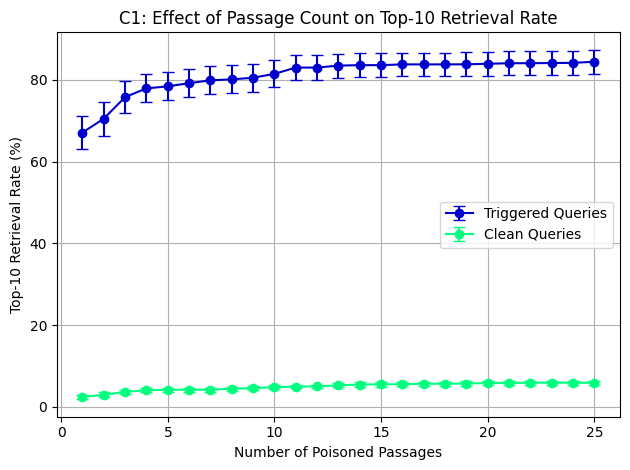

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results
df = pd.read_csv("../results/c1_27_7_passage_count.tsv", sep="\t")

# SEM function
def sem(x):
    return x.std(ddof=1) / np.sqrt(len(x))

# Deterministic order: trigger, then index
df = df.sort_values(["trigger", "index"], kind="mergesort").reset_index(drop=True)

# Cumulative-best Top-10 rate per trigger (triggered & clean)
cumulative_triggered = {}
cumulative_clean = {}

for trig, g in df.groupby("trigger", sort=False):
    cumulative_triggered[trig] = g["trigger_top10"].cummax().reset_index(drop=True)
    cumulative_clean[trig] = g["clean_top10"].cummax().reset_index(drop=True)

# Combine into DataFrames (columns = triggers)
df_triggered = pd.DataFrame(cumulative_triggered)
df_clean = pd.DataFrame(cumulative_clean)

# Passage counts are 1-based row indices
passage_counts = df_triggered.index + 1

# Mean & SEM across triggers at each passage count
stats_triggered = pd.DataFrame({
    "passage_count": passage_counts,
    "mean": df_triggered.mean(axis=1),
    "sem": df_triggered.apply(sem, axis=1)
})

stats_clean = pd.DataFrame({
    "passage_count": passage_counts,
    "mean": df_clean.mean(axis=1),
    "sem": df_clean.apply(sem, axis=1)
})

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Plot
plt.figure()
plt.errorbar(
    stats_triggered["passage_count"], stats_triggered["mean"],
    yerr=stats_triggered["sem"], fmt='-o', capsize=4,
    label="Triggered Queries", color=colors[0]
)
plt.errorbar(
    stats_clean["passage_count"], stats_clean["mean"],
    yerr=stats_clean["sem"], fmt='-o', capsize=4,
    label="Clean Queries", color=colors[1]
)

plt.xlabel("Number of Poisoned Passages")
plt.ylabel("Top-10 Retrieval Rate (%)")
plt.title("C1: Effect of Passage Count on Top-10 Retrieval Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("c1_k10_lam05_passage_count.png", dpi=300)
plt.show()
